## Overview of data:
- All 4 datasets from MovieLens are stored in the central movies.db database.
- The 4 datasets are as follows:
    - **links.csv**: links the *movieId* (what we are using as our unique identifier) with the imdbId (which will be helpful when eventually referencing IMDB for plot info and images).
    - **movies.csv**: contains the *title* and *genre* for each *movieId*.
        - *sidenote*: the actual table in the db.file is called '*movielens*'.
    - **ratings.csv**: contains the *rating* that each user (denoted by a *userId*) gave a particular movie (linked to its *movieId*) at a particular time (represented by a *timestamp* as a string). Note that each user rated multiple movies.
    - **tags.csv**: contains the *tags* that a particular user (linked to his/her *userId*) gave to a particular movie (linked to its *movieId*), also at a particular *timestamp*. Note that each user tags multiple movies, and in turn may apply multiple tags to each movie.
- In SQL commands, when joining data, all queries should be joined on the **movieId**, since this is the common, unique identifier between all tables in the database.

In [1]:
import pandas as pd
import sqlite3
import numpy as np

In [2]:
db = sqlite3.connect('data/movies.db')

In [3]:
query = '''SELECT title, genres, ratings.*, tags.tag, tags.timestamp AS ts
            FROM movielens
            JOIN ratings ON movielens.movieId = ratings.movieId
            LEFT JOIN tags ON movielens.movieID = tags.movieID AND ratings.userId = tags.userId
         '''
df = pd.read_sql(query, db)
df.head()

,title,genres,userId,movieId,rating,timestamp,tag,ts
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,4.0,2000-07-30 18:45:03,None,None
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,1,4.0,1996-11-08 06:36:02,None,None
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,1,4.5,2005-01-25 06:52:26,None,None
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,1,2.5,2017-11-13 12:59:30,None,None
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,1,4.5,2011-05-18 05:28:03,None,None


_______________________

# Functions

_______________________

## Function that extracts the various genres (from the 'genres' column) and creates multiple genre columns out of it.
- ...where each movie/row will contain a *1* if it corresponds to that genre, and a *0* if not.

In [4]:
def make_genre_columns(dataframe):
    #function that takes the 'genres' column (assuming it exists) from a 
    #dataframe and makes multiple "one-hot-encoding" genre columns out of it
    
    genres = list(dataframe['genres'].unique())
    
    genres_split = []
    for g in genres:
        sublist = g.split('|')
        genres_split.append(sublist)

    flat_list = [item for sublist in genres_split for item in sublist]

    def unique_list(list):
        a = []
        for b in list:
            if b not in a:
                a.append(b)
        return a
    
    unique_genres = unique_list(flat_list)
    
    for g in unique_genres:
        
        col_to_add = []
        for i in list(dataframe['genres']):
            if g in i:
                col_to_add.append(1)  
            else:
                col_to_add.append(0)
    
        dataframe['Genre_{}'.format(g)] = col_to_add
        
#     del dataframe['genres']
#     #optional

    return dataframe

##### Example:

In [5]:
test = make_genre_columns(df.copy())

test.head()

,title,genres,userId,movieId,rating,timestamp,tag,ts,Genre_Adventure,Genre_Animation,...,Genre_Horror,Genre_Mystery,Genre_Sci-Fi,Genre_War,Genre_Musical,Genre_Documentary,Genre_IMAX,Genre_Western,Genre_Film-Noir,Genre_(no genres listed)
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,4.0,2000-07-30 18:45:03,None,None,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,1,4.0,1996-11-08 06:36:02,None,None,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,1,4.5,2005-01-25 06:52:26,None,None,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,1,2.5,2017-11-13 12:59:30,None,None,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,1,4.5,2011-05-18 05:28:03,None,None,1,1,...,0,0,0,0,0,0,0,0,0,0


## Function that outputs a list of movieIds that satisfy given filter conditions.
- to start, this filter condition will be just the requested genre.
    - in other words, the user provides a preferred genre (via Django interface, eventually) and this function returns a list of movieIds that belong to that genre.

In [6]:
def get_movies_by_genre(dataframe, genre):
    ids = dataframe['movieId']
    bools = dataframe['Genre_{}'.format(genre)].values
    z = list(zip(ids, bools))
    list_movies = []
    for pair in z:
        if pair[1] == 1:
            list_movies.append(pair[0])
            
    def unique_list(list):
        a = []
        for b in list:
            if b not in a:
                a.append(b)
        return a
    
    return unique_list(list_movies)

##### Example:

In [7]:
adventure_movies = get_movies_by_genre(test, 'Adventure')
fantasy_movies = get_movies_by_genre(test, 'Fantasy')
horror_movies = get_movies_by_genre(test, 'Horror')
IMAX_movies = get_movies_by_genre(test, 'IMAX')

horror_movies[:10]

[12, 22, 70, 92, 93, 152, 177, 183, 188, 196]

### Combined Function: extract the various genres (from the 'genres' column), create multiple genre columns out of it, then output a list of movies that satisfy requested genre.

In [8]:
def movieIds_by_genre(dataframe, desired_genre):
    
    genres = list(dataframe['genres'].unique())
    
    genres_split = []
    for g in genres:
        sublist = g.split('|')
        genres_split.append(sublist)

    flat_list = [item for sublist in genres_split for item in sublist]

    def unique_list(list):
        a = []
        for b in list:
            if b not in a:
                a.append(b)
        return a
    
    unique_genres = unique_list(flat_list)
    
    for g in unique_genres:
        
        col_to_add = []
        for i in list(dataframe['genres']):
            if g in i:
                col_to_add.append(1)  
            else:
                col_to_add.append(0)
    
        dataframe['Genre_{}'.format(g)] = col_to_add
        
#     del dataframe['genres']
#     #optional

    ids = dataframe['movieId']
    bools = dataframe['Genre_{}'.format(desired_genre)].values
    z = list(zip(ids, bools))
    list_movies = []
    for pair in z:
        if pair[1] == 1:
            list_movies.append(pair[0])
    
    return unique_list(list_movies)

##### Example:

In [9]:
x = df.copy()
movieIds_by_genre(x, 'Documentary')

[77,
 99,
 108,
 116,
 128,
 137,
 162,
 206,
 246,
 363,
 556,
 581,
 602,
 722,
 759,
 791,
 1050,
 1111,
 1123,
 1144,
 1147,
 1189,
 1191,
 1192,
 1289,
 1310,
 1361,
 1649,
 1652,
 1797,
 1827,
 1856,
 2064,
 2323,
 2330,
 2494,
 2538,
 2659,
 2677,
 2693,
 2813,
 2824,
 2859,
 2930,
 2984,
 3002,
 3007,
 3077,
 3142,
 3182,
 3281,
 3303,
 3327,
 3539,
 3609,
 3625,
 3653,
 3677,
 3679,
 3680,
 3859,
 3865,
 3989,
 4102,
 4171,
 4217,
 4236,
 4237,
 4278,
 4304,
 4350,
 4445,
 4453,
 4458,
 4459,
 4711,
 4769,
 4783,
 4864,
 4961,
 5059,
 5137,
 5224,
 5239,
 5288,
 5325,
 5385,
 5483,
 5513,
 5619,
 5643,
 5669,
 5670,
 5684,
 5735,
 5736,
 5785,
 5820,
 5932,
 6005,
 6042,
 6062,
 6122,
 6123,
 6125,
 6195,
 6269,
 6289,
 6299,
 6306,
 6327,
 6331,
 6368,
 6375,
 6380,
 6400,
 6408,
 6433,
 6453,
 6598,
 6612,
 6667,
 6679,
 6692,
 6772,
 6775,
 6780,
 6869,
 6935,
 6938,
 6945,
 6948,
 6962,
 6963,
 6965,
 7096,
 7124,
 7141,
 7156,
 7171,
 7225,
 7256,
 7440,
 7443,
 7566,
 77

## Function for adding new user row to the tail of the existing DataFrame.

In [10]:
def add_new_user(dataframe):
    new_user_row = pd.DataFrame(np.zeros(shape=(1,len(dataframe.columns))),
                              columns=dataframe.columns)

    dfs_to_concat = [dataframe, new_user_row]
    combined = pd.concat(dfs_to_concat)
    return combined

##### Example:

In [11]:
query2 = "SELECT * FROM ratings"
df_sandbox = pd.read_sql(query2, db)
df_sandbox = df_sandbox.drop("timestamp", axis = 1)
df_sandbox = df_sandbox.set_index(["userId", "movieId"])
users_vs_movies_matrix = df_sandbox.unstack()
users_vs_movies_matrix = users_vs_movies_matrix.fillna(0)


# add_new_user(users_vs_movies_matrix).tail()
test_matrix = add_new_user(users_vs_movies_matrix)
test_matrix.tail()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
607        4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608        2.5    2.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
609        3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
610        5.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0    0.0   
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         ...                                                                   \
movieId  ...   193565 193567 193571 193573 193579 193581 193583 193585 193587   
607      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
609      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
610      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                
movieId 193609  
607        0.0  
608        0.0  
609        0.0  
610        0.0  
0          0.0  

[5 rows x 9724 columns]

## Function to generate dictionary for converting IMDB Id (used in Django interface) to MovieLens movieId (needed for DataFrame), and vice-versa.

In [18]:
def translator_dictionary():

    query3 = "SELECT movieId, imdbId FROM links"
    df_translator = pd.read_sql(query3, db)
    movie_IDs = list(df_translator['movieId'])
    IMDB_IDs = list(df_translator['imdbId'])


    ML_2_IMDB = dict(zip(movie_IDs, IMDB_IDs))
    IMDB_2_ML = dict(zip(IMDB_IDs, movie_IDs))
    
    return IMDB_2_ML

Format of input data (to be taken from Django interface):
- list of tuples, where each tuple represents (imdbId, Rating)

## Function for filling new user row with ratings inputted into Django interface

In [22]:
def convert_input(dataframe, django_data):
    
    translator = translator_dictionary()
    
    #Assuming that data coming from Django interface is a list of tuples
    for pair in django_data:
        movieId = translator[pair[0]]
        #dataframe['rating'][movieId][0] = pair[1] 
        #avoid above method, because it only returns a view/slice of a copy.
        dataframe.loc[0,('rating', movieId)] = pair[1] #where 0 represents userId = 0, aka the new user
    return list(dataframe.loc[0])

##### Example:

In [24]:
dummy_input = [(112572, 4.0), (113690, 5.0), (111003, 1.0), (33467, 3.0), (3837248, 3.0)]
output_list = convert_input(test_matrix, dummy_input)

# [i for i in output_list if i > 0]
len(output_list)

9724

### Combined Convert Input Function

In [25]:
def translator_dictionary():

    query3 = "SELECT movieId, imdbId FROM links"
    df_translator = pd.read_sql(query3, db)
    movie_IDs = list(df_translator['movieId'])
    IMDB_IDs = list(df_translator['imdbId'])


    ML_2_IMDB = dict(zip(movie_IDs, IMDB_IDs))
    IMDB_2_ML = dict(zip(IMDB_IDs, movie_IDs))
    
    return IMDB_2_ML

def convert_django(dataframe, django_data):
    
    new_user_row = pd.DataFrame(np.zeros(shape=(1,len(dataframe.columns))),
                              columns=dataframe.columns)

    dfs_to_concat = [dataframe, new_user_row]
    combined = pd.concat(dfs_to_concat)
    
    translator = translator_dictionary()
    
    #Assuming that data coming from Django interface is a list of tuples
    for pair in django_data:
        movieId = translator[pair[0]]
        combined.loc[0,('rating', movieId)] = pair[1] 
        #where 0 represents userId = 0, aka the new user
        
    return list(combined.loc[0])

  

##### Example:

In [119]:
django_test = [(114709, 4.0), (114885, 5.0), (114319, 1.0), (112302, 3.0), (3837248, 3.0)]
# b = convert_django(users_vs_movies_matrix, django_test)

In [120]:
users_vs_movies_matrix.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    0.0    4.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   
2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5          4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         ...                                                                   \
movieId  ...   193565 193567 193571 193573 193579 193581 193583 193585 193587   
userId   ...                                                                    
1        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                
movieId 193609  
userId          
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  

[5 rows x 9724 columns]

In [121]:
new_user_row = pd.DataFrame(np.zeros(shape=(1,len(users_vs_movies_matrix.columns))),
                              columns=users_vs_movies_matrix.columns)

dfs_to_concat = [users_vs_movies_matrix, new_user_row]
combined = pd.concat(dfs_to_concat)

combined.tail()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
607        4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608        2.5    2.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
609        3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
610        5.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0    0.0   
0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         ...                                                                   \
movieId  ...   193565 193567 193571 193573 193579 193581 193583 193585 193587   
607      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
609      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
610      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0        ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                
movieId 193609  
607        0.0  
608        0.0  
609        0.0  
610        0.0  
0          0.0  

[5 rows x 9724 columns]

In [122]:
translator = translator_dictionary()
    
for pair in django_test:
    movieId = translator[pair[0]]
    combined.loc[0,('rating', movieId)] = pair[1] 
    
combined.tail()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
607        4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608        2.5    2.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
609        3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0   
610        5.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0    0.0   
0          4.0    0.0    0.0    5.0    0.0    0.0    1.0    3.0    0.0    0.0   

         ...                                                                   \
movieId  ...   193565 193567 193571 193573 193579 193581 193583 193585 193587   
607      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
608      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
609      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
610      ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0        ...      0.0    0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0   

                
movieId 193609  
607        0.0  
608        0.0  
609        0.0  
610        0.0  
0          0.0  

[5 rows x 9724 columns]

### Convert MovieID to Title

In [27]:
query_ = "SELECT movieId, title FROM movielens"
df_ = pd.read_sql(query_, db)
df_.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [28]:
def convert_ids_to_titles(id_list):

    query = "SELECT movieId, title FROM movielens"
    df_translator = pd.read_sql(query, db)
    movie_IDs = list(df_translator['movieId'])
    titles = list(df_translator['title'])

    id_2_title = dict(zip(movie_IDs, titles))
    
    titles = []
    for i in id_list:
        titles.append(id_2_title[i])
    
    return titles

In [29]:
test_list = [260, 1198, 1196, 858, 1197, 
             608, 1265, 1270, 912, 1210, 
             1136, 593, 1097, 2858, 904, 
             1, 1208, 1307, 919, 1617,  
             1387, 1221, 2918, 1580,  
             2716, 1214, 1079, 356, 
             1193, 1213, 2762, 2028]


convert_ids_to_titles(test_list)

['Star Wars: Episode IV - A New Hope (1977)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Godfather, The (1972)',
 'Princess Bride, The (1987)',
 'Fargo (1996)',
 'Groundhog Day (1993)',
 'Back to the Future (1985)',
 'Casablanca (1942)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Monty Python and the Holy Grail (1975)',
 'Silence of the Lambs, The (1991)',
 'E.T. the Extra-Terrestrial (1982)',
 'American Beauty (1999)',
 'Rear Window (1954)',
 'Toy Story (1995)',
 'Apocalypse Now (1979)',
 'When Harry Met Sally... (1989)',
 'Wizard of Oz, The (1939)',
 'L.A. Confidential (1997)',
 'Jaws (1975)',
 'Godfather: Part II, The (1974)',
 "Ferris Bueller's Day Off (1986)",
 'Men in Black (a.k.a. MIB) (1997)',
 'Ghostbusters (a.k.a. Ghost Busters) (1984)',
 'Alien (1979)',
 'Fish Called Wanda, A (1988)',
 'Forrest Gump (1994)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Goodfellas 

### Convert MovieID to IMDB ID

In [32]:
def back_2_IMDB(id_list, database_directory):
    
    db = sqlite3.connect(database_directory)
    query = "SELECT movieId, imdbId FROM links"
    df_translator = pd.read_sql(query, db)
    movie_IDs = list(df_translator['movieId'])
    IMDB_IDs = list(df_translator['imdbId'])
    
    ML_2_IMDB = dict(zip(movie_IDs, IMDB_IDs))
    
    converted_ids = []
    for i in id_list:
        converted_ids.append(ML_2_IMDB[i])
    
    db.close()
    
    return converted_ids

##### Example:

In [33]:
database_directory = 'data/movies.db'
back_2_IMDB(test_list, database_directory)

[76759,
 82971,
 80684,
 68646,
 93779,
 116282,
 107048,
 88763,
 34583,
 86190,
 71853,
 102926,
 83866,
 169547,
 47396,
 114709,
 78788,
 98635,
 32138,
 119488,
 73195,
 71562,
 91042,
 119654,
 87332,
 78748,
 95159,
 109830,
 73486,
 99685,
 167404,
 120815]

In [57]:
df_PCA = x.copy()


df_PCA = df_PCA.drop("timestamp", axis = 1)
df_PCA = df_PCA.drop("genres", axis = 1)
df_PCA = df_PCA.drop("title", axis = 1)
df_PCA = df_PCA.drop("tag", axis = 1)
df_PCA = df_PCA.drop("ts", axis = 1)
df_PCA = df_PCA.drop("movieId", axis = 1)

df_PCA = df_PCA.set_index(["userId", "rating"])
# df_PCA = df_PCA.set_index(["userId", "movieId"])
# PCA_matrix = df_PCA.unstack(0)
# users_vs_movies_matrix = users_vs_movies_matrix.fillna(0)

# df_PCA
# PCA_matrix
users_vs_movies_matrix

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    0.0    4.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   
2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5          4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6          0.0    4.0    5.0    3.0    5.0    4.0    4.0    3.0    0.0    3.0   
7          4.5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8          0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
9          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11         0.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0    3.0   
12         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
13         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14         0.0    0.0    0.0    3.0    0.0    0.0    3.0    0.0    0.0    0.0   
15         2.5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
17         4.5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18         3.5    3.0    0.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   
19         4.0    3.0    3.0    0.0    0.0    0.0    2.0    0.0    0.0    2.0   
20         0.0    3.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
21         3.5    3.5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    5.0   
22         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
23         0.0    0.0    0.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   
24         0.0    0.0    0.0    0.0    0.0    4.5    0.0    0.0    0.0    0.0   
25         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
26         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    3.0   
27         3.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
28         0.0    0.0    0.0    0.0    0.0    3.5    0.0    0.0    0.0    0.0   
29         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
581        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
582        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
583        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
584        5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    5.0   
585        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
586        0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
587        5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
588        0.0    0.0    3.0    0.0    0.0    5.0    0.0    0.0    0.0    3.0   
589        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
590        4.0    2.5    3.0    0.0    2.0    3.5    0.0    0.0    0.0    3.5   
591        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
592        0.0    4.0    0.0    0.0    0.0    3.0    0.0    0.0    0.0    3.0   
593        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
594        0.0    4.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
595        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
596        4.0    0.0    0.0    0.0    

In [74]:
from sklearn.decomposition import PCA
df_demeaned = users_vs_movies_matrix - users_vs_movies_matrix.mean()
pca = PCA(n_components = 2)
X = df_demeaned
#fit on the data
pca.fit(X)
Xt = pca.transform(X)

In [75]:
pca.components_

array([[ 0.04666699,  0.0331169 ,  0.01251639, ..., -0.00017295,
        -0.00017295,  0.00013465],
       [ 0.02022417, -0.00021841,  0.02428748, ..., -0.00065547,
        -0.00065547, -0.00132808]])

In [76]:
pca.explained_variance_ratio_

array([0.13502093, 0.04383474])

In [77]:
df_PCA_results = pd.DataFrame(Xt, 
columns = [
    'Component1', 
    'Component2', 
#     'Component3', 
#     'Component4', 
#     'Component5',
], 
index = users_vs_movies_matrix.index).round(2)
df_PCA_results.head()

,Component1,Component2
userId,,
1,14.68,14.22
2,-10.65,-5.18
3,-12.66,-0.45
4,2.99,12.47
5,-9.65,3.51


In [79]:
df_PCA_results.sort_values(by='Component1').head()

,Component1,Component2
userId,,
175,-13.06,-0.91
442,-13.03,-0.63
406,-12.68,-0.84
3,-12.66,-0.45
578,-12.59,-1.84


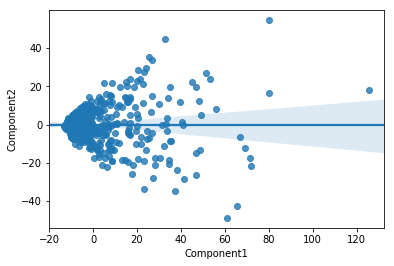

In [81]:
import seaborn as sns
%matplotlib inline
sns.regplot(x=df_PCA_results['Component1'], y=df_PCA_results['Component2'])

In [83]:
from sklearn.manifold import TSNE
X = users_vs_movies_matrix
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(610, 2)

In [85]:
df_TSNE_results = pd.DataFrame(X_embedded, 
columns = [
    'Component1', 
    'Component2', 
#     'Component3', 
#     'Component4', 
#     'Component5',
], 
index = users_vs_movies_matrix.index).round(2)
df_TSNE_results.head()

,Component1,Component2
userId,,
1,-5.87,0.35
2,3.59,-5.72
3,-1.61,-5.90
4,-2.61,-2.51
5,-1.15,3.67


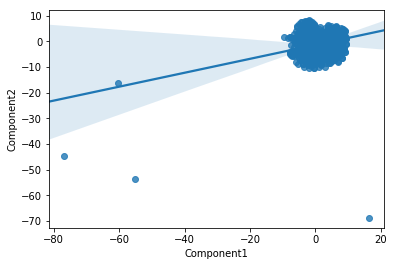

In [86]:
sns.regplot(x=df_TSNE_results['Component1'], y=df_TSNE_results['Component2'])

In [104]:
query3 = "SELECT movieId, imdbId FROM links"
df_translator = pd.read_sql(query3, db)
movie_IDs = list(df_translator['movieId'])
IMDB_IDs = list(df_translator['imdbId'])


ML_2_IMDB = dict(zip(movie_IDs, IMDB_IDs))
IMDB_2_ML = dict(zip(IMDB_IDs, movie_IDs))
    
ML_2_IMDB[193573]

3837248

In [ ]:
# db.close()